# Projet 8: Participez à la conception d'une voiture autonome

## Comparer les 3 modèles (Unet, PSPNet et VGG16FCN8)

## Importation des librairies nécessaires

In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 458.3 MB 6.3 kB/s  eta 0:00:01
     |████████████████████████████████| 462 kB 70.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 67.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 66.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 67.1 MB/s eta 0:00:01
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30705 sha256=cf88cc6643d3b25267a606aac9efafc645d43b853541b93af500865521e99e55
  Stored in directory: /home/azureuser/.cache/pip/wheels/22/4c/94/0583f60c9c5b6024ed64f290cb2d43b06bb4f75577dc3c93a7
Successfully built clang
ERROR: pyldavis 3.3.1 requires sklearn, which is not installed.
ERROR: pandas-ml 0.6.1 requires enum34, which is not installed.
ERROR: torchvision 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.10.1 which is incompatible.
ERROR: torch-tb-profiler 0.3.1 has requirement pandas>=1.0.0, but you'll have pandas 0.25.3 which is incompatible.
ERROR: tensorf

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
#from tensorflow.keras.applications.resnet50 import preprocess_input
#from tensorflow.keras.applications.vgg16 import preprocess_input

### Dèfinir les fonctions me permettant de passer de 32 sous catégories à seulement 8 catégories

In [3]:
cats = {
 'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

def convertCats(x):
    if x in cats['void']:
        return 0
    elif x in cats['flat']:
        return 1
    elif x in cats['construction']:
        return 2
    elif x in cats['object']:
        return 3
    elif x in cats['nature']:
        return 4
    elif x in cats['sky']:
        return 5
    elif x in cats['human']:
        return 6
    elif x in cats['vehicle']:
        return 7
    
convertCats_v = np.vectorize(convertCats)

def preprocessImg(img):
    image_matrix = np.expand_dims(img, 2)
    
    converted_image = convertCats_v(image_matrix)
    return converted_image

### Dèfinir les fonctions pertes

In [4]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3])+K.sum(y_pred, [1, 2, 3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def _dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

### Prèparer les 4 images

#### Première image identique

In [5]:
img1_unet = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png', target_size=(128, 128))
img1_pspnet = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png', target_size=(384,384)) 
img1_vgg16fcn = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png', target_size=(256,256)) 

#### Deuxième image identique

In [6]:
img2_unet = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000576_leftImg8bit.png', target_size=(128, 128))
img2_pspnet = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000576_leftImg8bit.png', target_size=(384,384)) 
img2_vgg16fcn = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000576_leftImg8bit.png', target_size=(256,256)) 

#### Troisième image identique

In [7]:
img3_unet = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_001016_leftImg8bit.png', target_size=(128, 128))
img3_pspnet = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_001016_leftImg8bit.png', target_size=(384,384)) 
img3_vgg16fcn = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_001016_leftImg8bit.png', target_size=(256,256)) 

#### Quatrième image identique

In [8]:
img4_unet = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png', target_size=(128, 128))
img4_pspnet = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png', target_size=(384,384)) 
img4_vgg16fcn = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png', target_size=(256,256)) 

### Prèparer les 4 masks

#### Première mask identique

In [9]:
mask1_unet = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png', target_size=(128, 128), color_mode="grayscale")
mask1_pspnet = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png', target_size=(384,384), color_mode="grayscale") 
mask1_vgg16fcn = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png', target_size=(256,256), color_mode="grayscale") 

#### Deuxième mask identique

In [10]:
mask2_unet = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_000576_gtFine_labelIds.png', target_size=(128, 128), color_mode="grayscale")
mask2_pspnet = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_000576_gtFine_labelIds.png', target_size=(384,384), color_mode="grayscale") 
mask2_vgg16fcn = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_000576_gtFine_labelIds.png', target_size=(256,256), color_mode="grayscale") 

#### Troisième mask identique

In [11]:
mask3_unet = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_001016_gtFine_labelIds.png', target_size=(128, 128), color_mode="grayscale")
mask3_pspnet = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_001016_gtFine_labelIds.png', target_size=(384,384), color_mode="grayscale") 
mask3_vgg16fcn = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_001016_gtFine_labelIds.png', target_size=(256,256), color_mode="grayscale") 

#### Quatrième mask identique

In [12]:
mask4_unet = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png', target_size=(128, 128), color_mode="grayscale")
mask4_pspnet = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png', target_size=(384,384), color_mode="grayscale") 
mask4_vgg16fcn = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png', target_size=(256,256), color_mode="grayscale") 

### Charger mes 3 modèles

In [13]:
unet = load_model('model_avance.h5', compile=False)
pspnet = load_model('model_PSPNet.h5', compile=False)
vgg16fcn = load_model('model_VGG16FCN.h5', compile=False)

### Prédire (modèle unet)

In [14]:
from tensorflow.keras.applications.resnet50 import preprocess_input

#### Prédiction 1 

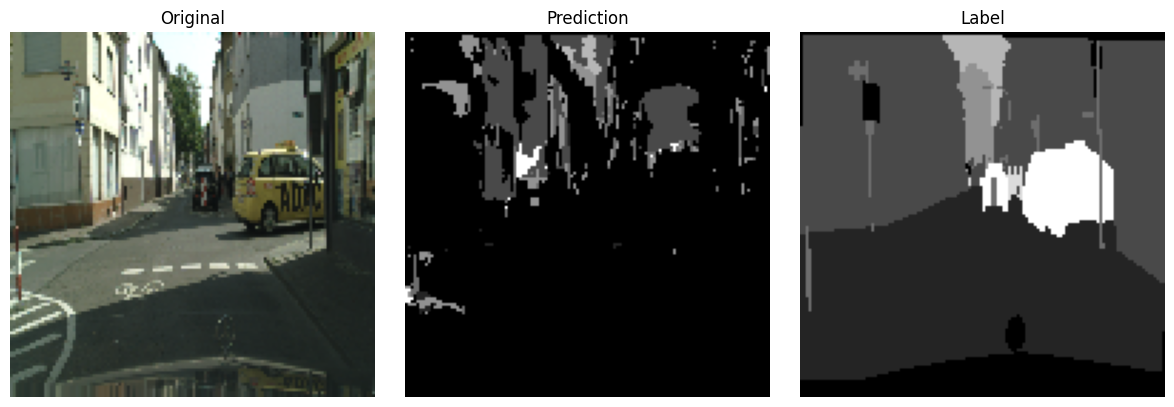

In [15]:
x = image.img_to_array(img1_unet)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = unet.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask1_unet)[:,:,0]


plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img1_unet)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

#### Prédiction 2 

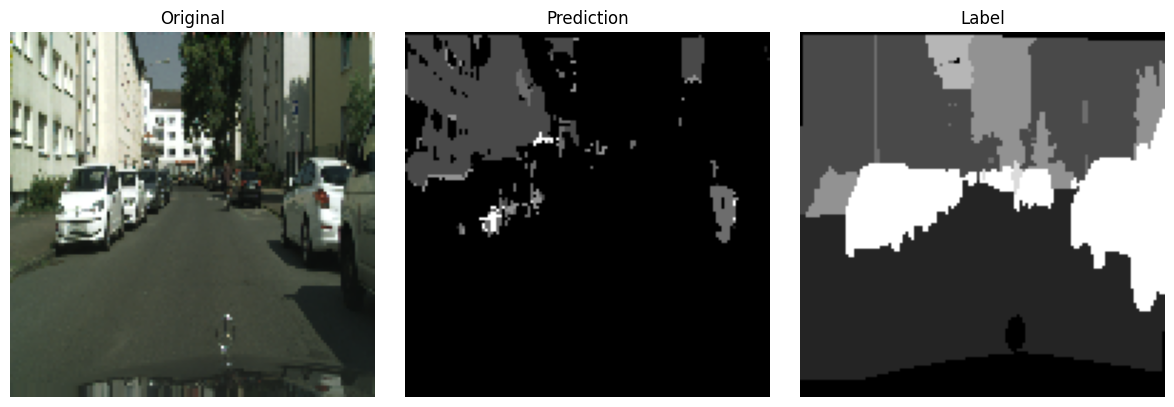

In [20]:
x = image.img_to_array(img2_unet)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = unet.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask2_unet)[:,:,0]


plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img2_unet)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

#### Prédiction 3 

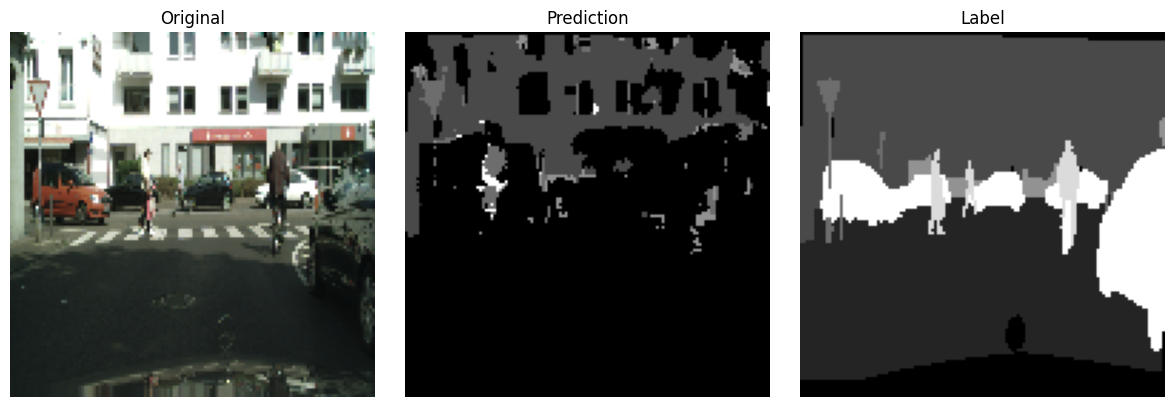

In [21]:
x = image.img_to_array(img3_unet)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = unet.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask3_unet)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img3_unet)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

#### Prédiction 4 

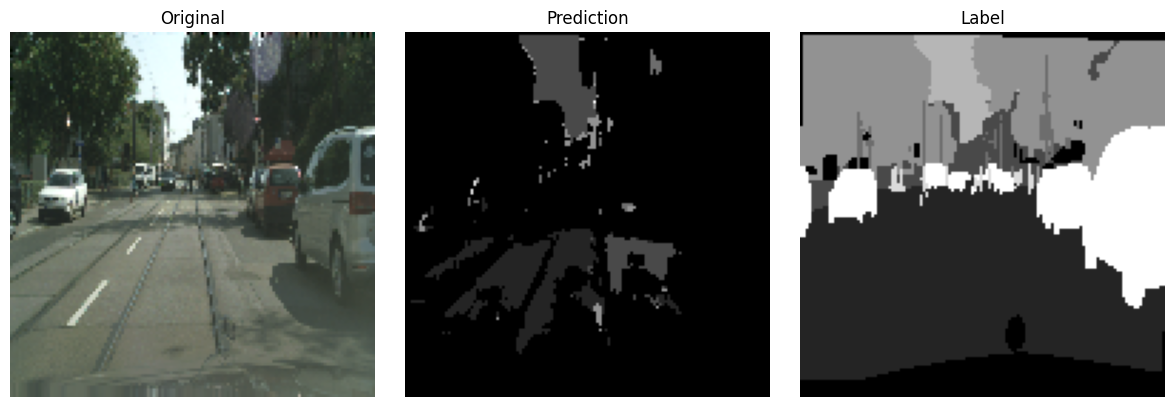

In [22]:
x = image.img_to_array(img4_unet)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = unet.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask4_unet)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img4_unet)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

### Prédire (modèle pspnet)

#### Prédiction 1

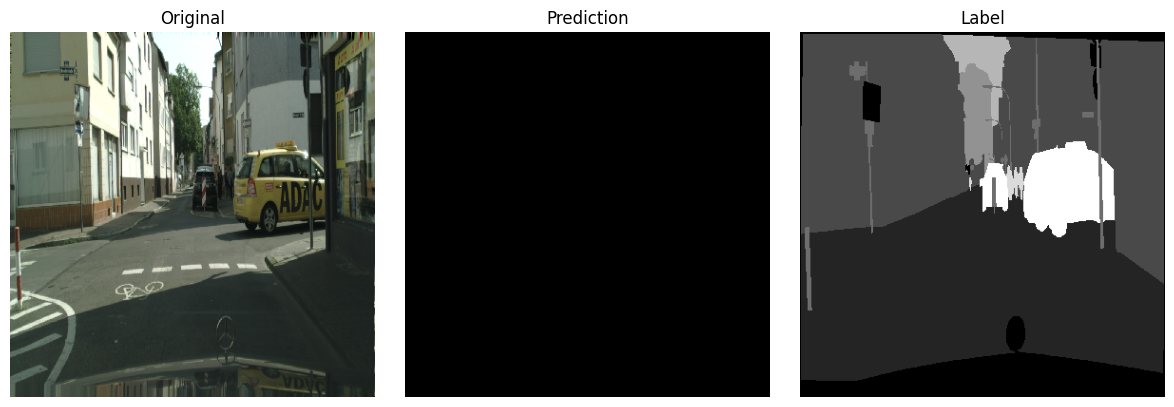

In [23]:
x = image.img_to_array(img1_pspnet)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = pspnet.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask1_pspnet)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img1_pspnet)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

#### Prédiction 2

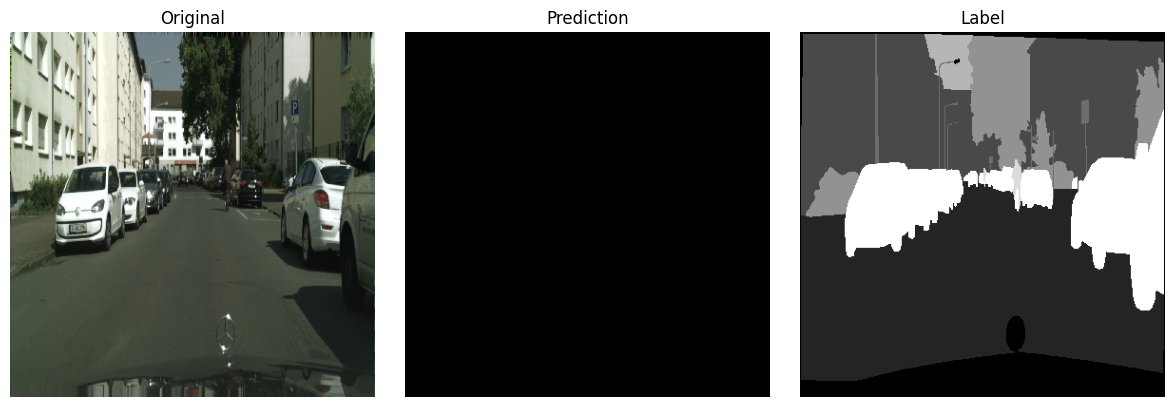

In [24]:
x = image.img_to_array(img2_pspnet)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = pspnet.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask2_pspnet)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img2_pspnet)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

#### Prédiction 3

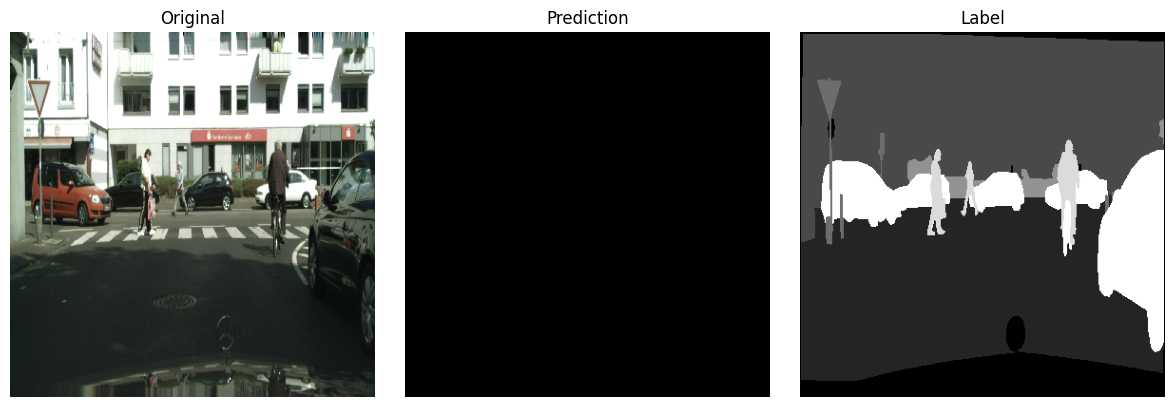

In [26]:
x = image.img_to_array(img3_pspnet)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = pspnet.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask3_pspnet)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img3_pspnet)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

#### Prédiction 4

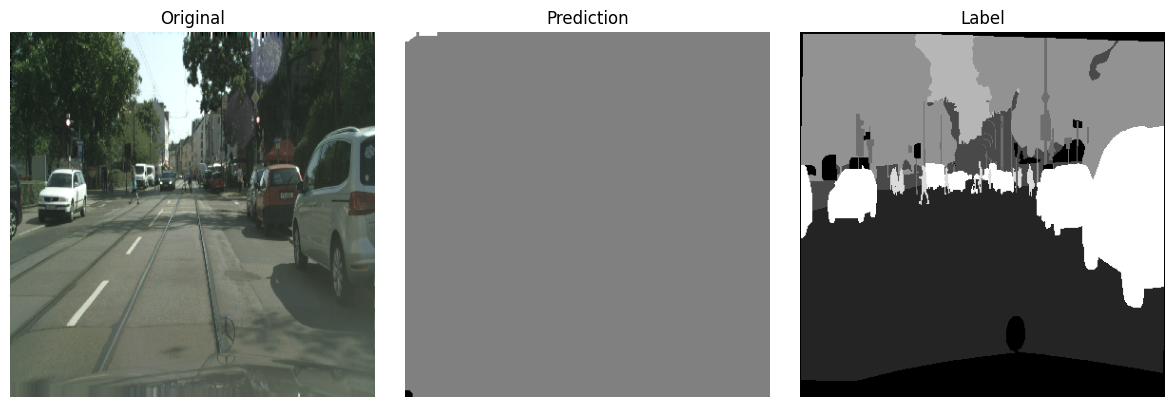

In [27]:
x = image.img_to_array(img4_pspnet)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = pspnet.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask4_pspnet)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img4_pspnet)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

### Prédire (modèle vgg16fcn)

In [28]:
from tensorflow.keras.applications.vgg16 import preprocess_input

#### Prédiction 1

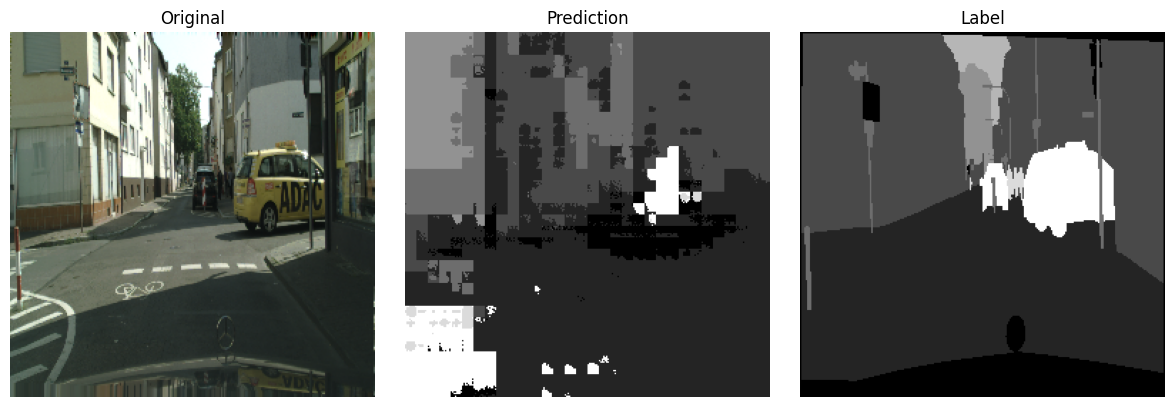

In [29]:
x = image.img_to_array(img1_vgg16fcn)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = vgg16fcn.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask1_vgg16fcn)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img1_vgg16fcn)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

#### Prédiction 2

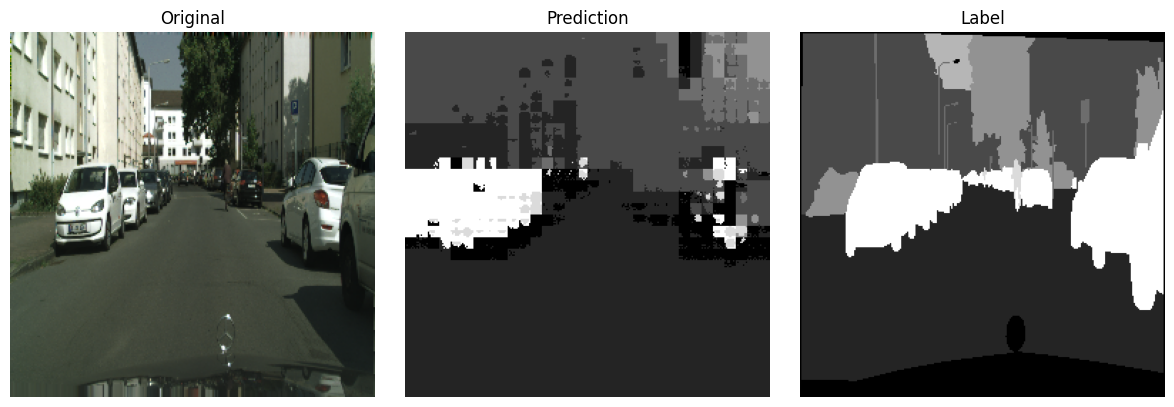

In [30]:
x = image.img_to_array(img2_vgg16fcn)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = vgg16fcn.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask2_vgg16fcn)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img2_vgg16fcn)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

#### Prédiction 3

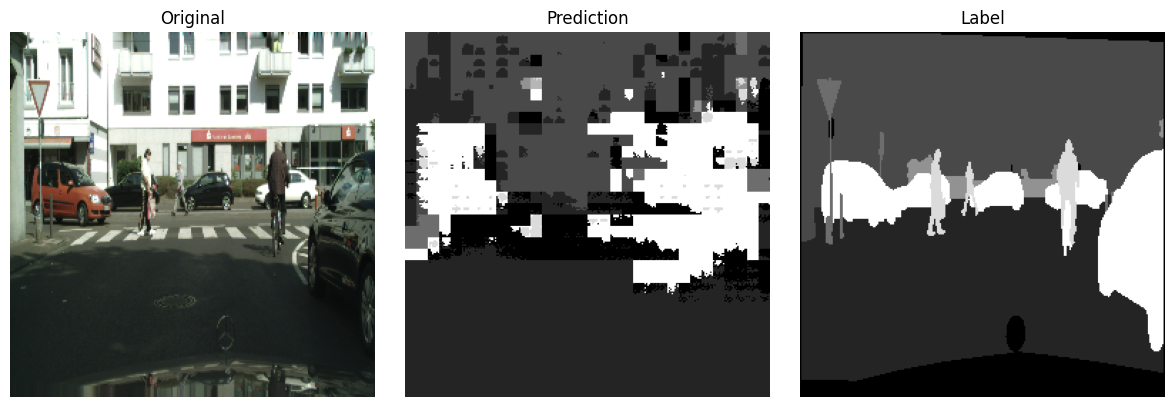

In [31]:
x = image.img_to_array(img3_vgg16fcn)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = vgg16fcn.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask3_vgg16fcn)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img3_vgg16fcn)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

#### Prédiction 4

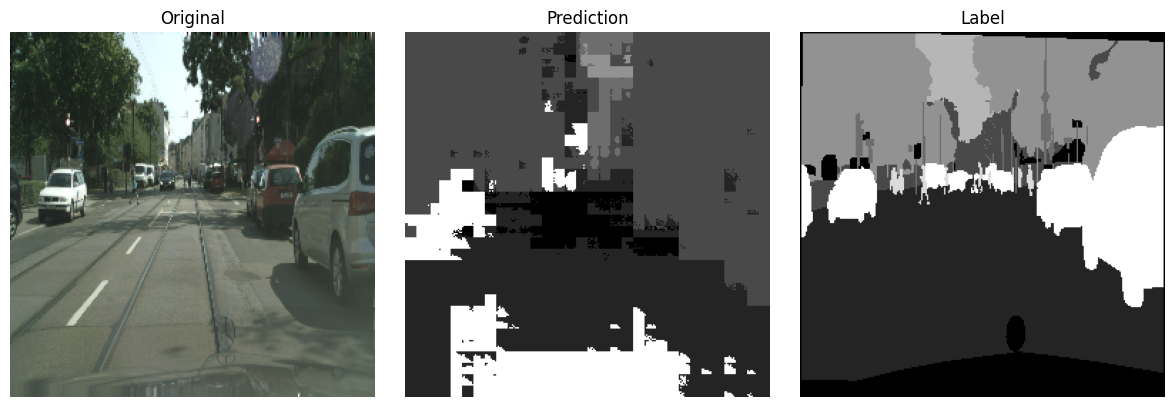

In [32]:
x = image.img_to_array(img4_vgg16fcn)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = vgg16fcn.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask4_vgg16fcn)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img4_vgg16fcn)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()